## Feature Pyramid Networks (FPN) and Fully Convolutional Network (FCN)

If you want to perform validation, only need to skip the two **Train and Valid** sections and run the rest in sequence.

In [33]:
!pip install datasets
!pip install evaluate
!pip install segmentation-models-pytorch
!pip install huggingface-hub
!pip install pycocotools
!pip install google-colab
!pip install datasets
!pip install numpy
!pip install matplotlib
!pip install torch torchvision torchaudio
!pip install albumentations
!pip install opencv-python
!pip install tqdm
!pip install evaluate
!pip install segmentation-models-pytorch
!pip install pillow
!pip install huggingface-hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 48.6 MB/s eta 0:00:00


In [37]:
from pycocotools.coco import COCO
from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from torch.utils.data import DataLoader
from tqdm import tqdm
from torchvision import models
import evaluate
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn import CrossEntropyLoss
from torchvision.models.segmentation import fcn_resnet101, FCN_ResNet101_Weights
import torch.nn as nn
from segmentation_models_pytorch import FPN
from matplotlib import pyplot as plt
from PIL import Image, ImageFilter
from huggingface_hub import hf_hub_download

import warnings
warnings.filterwarnings("ignore")

### Dataset Loader

In [38]:
repo_id = "EnmmmmOvO/SeaTurtleID2022_9517Project"

coco = COCO(hf_hub_download(repo_id=repo_id,filename="annotations.json"))
ds = load_dataset("EnmmmmOvO/SeaTurtleID2022")['train']

# color:          backgtound    turtle      flipper       head
COLOR = np.array([[0, 0, 0], [65, 105, 225],[50, 205, 50], [255, 255, 0]])
SPLIT = 'split_open'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
TRAIN_EPOCHS = 15

loading annotations into memory...
Done (t=3.70s)
creating index...
index created!


#### Split dataset by `split_open`

In [5]:
train_dataset = ds.filter(lambda x: x[SPLIT] == 'train')
valid_dataset = ds.filter(lambda x: x[SPLIT] == 'valid')
test_dataset = ds.filter(lambda x: x[SPLIT] == 'test')

Filter:   0%|          | 0/8729 [00:00<?, ? examples/s]

Filter:   0%|          | 0/8729 [00:00<?, ? examples/s]

Filter:   0%|          | 0/8729 [00:00<?, ? examples/s]

#### Extract result mask from `annotations.json` by COCO

In [39]:
def get_mask(id: str | int):
    id = int(id)
    anns = coco.loadAnns(coco.getAnnIds(imgIds=id, catIds=coco.getCatIds(), iscrowd=None))
    mask = np.zeros((coco.imgs[id]['height'], coco.imgs[id]['width']), dtype=int)
    for ann in anns:
        submask = coco.annToMask(ann)
        mask = np.maximum(mask, submask * ann['category_id'])
    return mask

The mask in `annotations.json` and the corresponding image extraction effect are displayed.

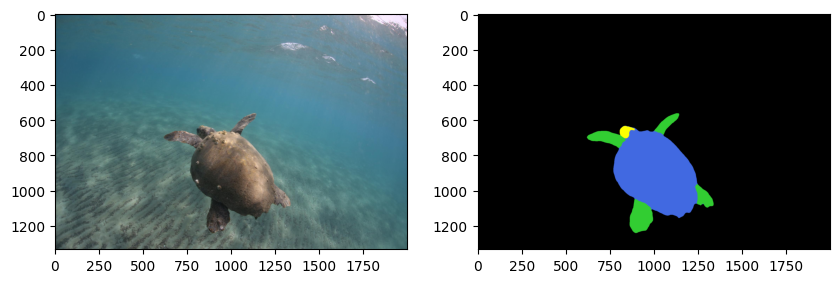

In [40]:
plt.figure(figsize=(10, 20))

index = 3000

plt.subplot(1, 2, 1)
plt.imshow(ds[index - 1]['image'])
plt.subplot(1, 2, 2)
mask = get_mask(index)
plt.imshow(COLOR[mask])
plt.show()

#### Image Processing

Since fcn and fpn require different input image latitudes, they are processed separately.

In [41]:
class TurtleDataset(Dataset):
    def __init__(self, dataset, transform=None, rotate=None):
        self.dataset = dataset
        self.transform = transform
        self.rotate = rotate

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        id = self.dataset[index]['id']
        image = np.array(self.dataset[index]['image'])
        mask = np.array(get_mask(id))

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        if self.rotate:
            image = torch.tensor(image).permute(2, 0, 1)

        return image, mask

Since data augmentation is added to the trained transform, the albumentations library is used to ensure that the image and mask change in the same way in order to ensure that the mask has the same variation.



In [42]:
train_transform = A.Compose([
    A.Resize(256, 256, always_apply=True),
    A.HorizontalFlip(p=0.4),
    A.RandomBrightnessContrast(p=0.15),
    A.Rotate(limit=20),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
], is_check_shapes=False, additional_targets={'mask': 'mask'})

image_transform = A.Compose([
    A.Resize(256, 256, always_apply=True),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
], is_check_shapes=False)

### FCN

The FCN (Fully Convolutional Network) model is a neural network architecture designed for image segmentation, generating pixel-wise classification predictions through convolution and upsampling.

In `fcn_resnet101`, ResNet serves as the backbone network, extracting deep features that FCN further processes for pixel-level segmentation.

By default, the PyTorch library's pre-trained models are often set up for 21-class segmentation (such as in COCO or Pascal VOC datasets), so this adjustment tailors the model to fit the specific requirement of a 4-class segmentation.

In [60]:
model = fcn_resnet101(weights=FCN_ResNet101_Weights.DEFAULT).to(device)
model.classifier[4] = nn.Conv2d(512, 4, kernel_size=1)
model = model.to(device)

In [61]:
train = TurtleDataset(train_dataset, train_transform, rotate=True)
valid = TurtleDataset(valid_dataset, image_transform, rotate=True)
test = TurtleDataset(test_dataset, image_transform, rotate=True)

In [62]:
train_loader = DataLoader(train, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid, batch_size=32, shuffle=False)
test_loader = DataLoader(test, batch_size=32, shuffle=False)

#### Train and Valid

Set the optimizer to AdamW, with an initial learning rate of 0.0001 and a slight weight decay to prevent overfitting.

Set the learning rate scheduler to reduce the learning rate to 10% when the validation loss stops decreasing.


In [ ]:
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
train_losses, valid_losses = [], []
train_accuracies, valid_accuracies = [], []
train_iou_scores, valid_iou_scores = [], []

iou_metric = evaluate.load("mean_iou")

for epoch in range(TRAIN_EPOCHS):
    # Train Part
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    train_iou_score = 0.0

    for batch_idx, (data, target) in enumerate(tqdm(train_loader, desc=f'Epoch {epoch+1}/{TRAIN_EPOCHS}')):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs["out"], target.long())
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        preds = outputs["out"].argmax(dim=1)
        total_correct += (preds == target).sum().item()
        total_samples += target.numel()

        iou_metric.add_batch(predictions=preds.cpu().numpy(), references=target.cpu().numpy())

    train_iou_result = iou_metric.compute(num_labels=4, ignore_index=-1)

    avg_train_iou = train_iou_result["mean_iou"]
    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = train_iou_result["mean_accuracy"]

    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    train_iou_scores.append(avg_train_iou)

    print(f'Epoch [{epoch+1}/{TRAIN_EPOCHS}], Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Train IoU: {avg_train_iou:.4f}')

    # Valid Part
    model.eval()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    valid_iou_score = 0.0

    iou_metric = evaluate.load("mean_iou")

    with torch.no_grad():
        for data, target in tqdm(valid_loader, desc='Validating'):
            data, target = data.to(device), target.to(device)

            outputs = model(data)
            loss = criterion(outputs["out"], target.long())

            total_loss += loss.item()

            preds = outputs["out"].argmax(dim=1)
            total_correct += (preds == target).sum().item()
            total_samples += target.numel()

            iou_metric.add_batch(predictions=preds.cpu().numpy(), references=target.cpu().numpy())

    valid_iou_result = iou_metric.compute(num_labels=4, ignore_index=-1)

    avg_valid_iou = valid_iou_result["mean_iou"]
    avg_valid_loss = total_loss / len(valid_loader)
    valid_accuracy = valid_iou_result["mean_accuracy"]

    valid_losses.append(avg_valid_loss)
    valid_accuracies.append(valid_accuracy)
    valid_iou_scores.append(avg_valid_iou)

    # torch.save(model.state_dict(), f'/content/drive/MyDrive/pth/FCN/epoch_{epoch + 1}.pth')

    print(f'Epoch [{epoch+1}/{TRAIN_EPOCHS}], Valid Loss: {avg_valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.4f}, Valid IoU: {avg_valid_iou:.4f}')

    scheduler.step(avg_valid_loss)

Epoch 1/15: 100%|██████████| 166/166 [09:48<00:00,  3.54s/it]


Epoch [1/15], Train Loss: 0.3282, Train Accuracy: 0.8665, Train IoU: 0.7273


Validating: 100%|██████████| 35/35 [01:41<00:00,  2.89s/it]


Epoch [1/15], Valid Loss: 0.1437, Valid Accuracy: 0.9168, Valid IoU: 0.8445


Epoch 2/15: 100%|██████████| 166/166 [09:41<00:00,  3.50s/it]


Epoch [2/15], Train Loss: 0.0972, Train Accuracy: 0.9282, Train IoU: 0.8732


Validating: 100%|██████████| 35/35 [01:41<00:00,  2.91s/it]


Epoch [2/15], Valid Loss: 0.0703, Valid Accuracy: 0.9289, Valid IoU: 0.8775


Epoch 3/15: 100%|██████████| 166/166 [09:52<00:00,  3.57s/it]


Epoch [3/15], Train Loss: 0.0585, Train Accuracy: 0.9400, Train IoU: 0.8955


Validating: 100%|██████████| 35/35 [01:39<00:00,  2.84s/it]


Epoch [3/15], Valid Loss: 0.0511, Valid Accuracy: 0.9482, Valid IoU: 0.8844


Epoch 4/15: 100%|██████████| 166/166 [09:44<00:00,  3.52s/it]


Epoch [4/15], Train Loss: 0.0452, Train Accuracy: 0.9444, Train IoU: 0.9024


Validating: 100%|██████████| 35/35 [01:38<00:00,  2.81s/it]


Epoch [4/15], Valid Loss: 0.0399, Valid Accuracy: 0.9513, Valid IoU: 0.8998


Epoch 5/15: 100%|██████████| 166/166 [09:44<00:00,  3.52s/it]


Epoch [5/15], Train Loss: 0.0367, Train Accuracy: 0.9526, Train IoU: 0.9153


Validating: 100%|██████████| 35/35 [01:38<00:00,  2.81s/it]


Epoch [5/15], Valid Loss: 0.0354, Valid Accuracy: 0.9419, Valid IoU: 0.9003


Epoch 6/15: 100%|██████████| 166/166 [09:40<00:00,  3.50s/it]


Epoch [6/15], Train Loss: 0.0390, Train Accuracy: 0.9448, Train IoU: 0.9030


Validating: 100%|██████████| 35/35 [01:38<00:00,  2.83s/it]


Epoch [6/15], Valid Loss: 0.0435, Valid Accuracy: 0.9216, Valid IoU: 0.8768


Epoch 7/15: 100%|██████████| 166/166 [09:47<00:00,  3.54s/it]


Epoch [7/15], Train Loss: 0.0344, Train Accuracy: 0.9492, Train IoU: 0.9097


Validating: 100%|██████████| 35/35 [01:39<00:00,  2.85s/it]


Epoch [7/15], Valid Loss: 0.0314, Valid Accuracy: 0.9455, Valid IoU: 0.9031


Epoch 8/15: 100%|██████████| 166/166 [09:47<00:00,  3.54s/it]


Epoch [8/15], Train Loss: 0.0288, Train Accuracy: 0.9571, Train IoU: 0.9224


Validating: 100%|██████████| 35/35 [01:39<00:00,  2.86s/it]


Epoch [8/15], Valid Loss: 0.0297, Valid Accuracy: 0.9447, Valid IoU: 0.9086


Epoch 9/15: 100%|██████████| 166/166 [09:47<00:00,  3.54s/it]


Epoch [9/15], Train Loss: 0.0264, Train Accuracy: 0.9601, Train IoU: 0.9275


Validating: 100%|██████████| 35/35 [01:40<00:00,  2.87s/it]


Epoch [9/15], Valid Loss: 0.0282, Valid Accuracy: 0.9419, Valid IoU: 0.9098


Epoch 10/15: 100%|██████████| 166/166 [09:44<00:00,  3.52s/it]


Epoch [10/15], Train Loss: 0.0246, Train Accuracy: 0.9625, Train IoU: 0.9313


Validating: 100%|██████████| 35/35 [01:39<00:00,  2.85s/it]


Epoch [10/15], Valid Loss: 0.0272, Valid Accuracy: 0.9512, Valid IoU: 0.9145


Epoch 11/15: 100%|██████████| 166/166 [09:46<00:00,  3.53s/it]


Epoch [11/15], Train Loss: 0.0233, Train Accuracy: 0.9639, Train IoU: 0.9334


Validating: 100%|██████████| 35/35 [01:39<00:00,  2.84s/it]


Epoch [11/15], Valid Loss: 0.0261, Valid Accuracy: 0.9539, Valid IoU: 0.9175


Epoch 12/15: 100%|██████████| 166/166 [09:52<00:00,  3.57s/it]


Epoch [12/15], Train Loss: 0.0230, Train Accuracy: 0.9635, Train IoU: 0.9327


Validating: 100%|██████████| 35/35 [01:38<00:00,  2.82s/it]


Epoch [12/15], Valid Loss: 0.0261, Valid Accuracy: 0.9489, Valid IoU: 0.9149


Epoch 13/15: 100%|██████████| 166/166 [09:43<00:00,  3.52s/it]


Epoch [13/15], Train Loss: 0.0233, Train Accuracy: 0.9636, Train IoU: 0.9329


Validating: 100%|██████████| 35/35 [01:38<00:00,  2.81s/it]


Epoch [13/15], Valid Loss: 0.0353, Valid Accuracy: 0.9433, Valid IoU: 0.8996


Epoch 14/15: 100%|██████████| 166/166 [09:49<00:00,  3.55s/it]


Epoch [14/15], Train Loss: 0.0349, Train Accuracy: 0.9468, Train IoU: 0.9051


Validating: 100%|██████████| 35/35 [01:39<00:00,  2.85s/it]


Epoch [14/15], Valid Loss: 0.0299, Valid Accuracy: 0.9420, Valid IoU: 0.9017


Epoch 15/15: 100%|██████████| 166/166 [09:45<00:00,  3.53s/it]


Epoch [15/15], Train Loss: 0.0245, Train Accuracy: 0.9601, Train IoU: 0.9271


Validating: 100%|██████████| 35/35 [01:38<00:00,  2.81s/it]


Epoch [15/15], Valid Loss: 0.0270, Valid Accuracy: 0.9517, Valid IoU: 0.9100


##### Train and validate image generation

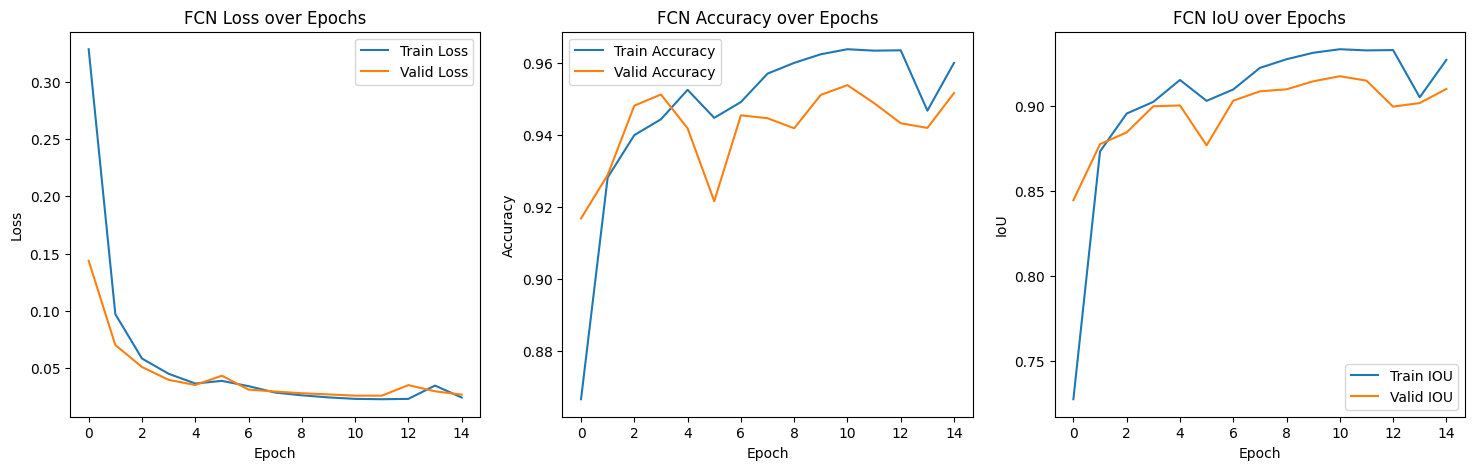

In [ ]:
plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('FCN Loss over Epochs')

plt.subplot(1, 3, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(valid_accuracies, label='Valid Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('FCN Accuracy over Epochs')

plt.subplot(1, 3, 3)
plt.plot(train_iou_scores, label='Train IOU')
plt.plot(valid_iou_scores, label='Valid IOU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()
plt.title('FCN IoU over Epochs')

plt.show()

#### Evaluation

To simplify the process of transmission, I uploaded the translation model to Hugging Face for validation.
[]()

In [63]:
pth = hf_hub_download(repo_id=repo_id, filename="FCN.pth")
model.load_state_dict(torch.load(pth))

<All keys matched successfully>

In [64]:
iou_metric = evaluate.load("mean_iou")

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for data, target in tqdm(test_loader):
        data, target = data.to(device), target.to(device)

        outputs = model(data)
        preds = outputs["out"].argmax(dim=1).cpu().numpy()
        labels = target.cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels)

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

num_classes = 4
iou_result = iou_metric.compute(predictions=all_preds, references=all_labels, num_labels=4, ignore_index=-1)

print(f"""FCN (Resnet101)
  Mean IoU: {iou_result['mean_iou']:.4f}
  Mean Accuracy: {iou_result['mean_accuracy']:.4f}

  Mean IoU of backdrop: {iou_result['per_category_iou'][0]:.4f}
  Mean Accuracy of backdrop: {iou_result['per_category_accuracy'][0]:.4f}

  Mean IoU of turtle: {iou_result['per_category_iou'][1]:.4f}
  Mean Accuracy of turtle: {iou_result['per_category_accuracy'][1]:.4f}

  Mean IoU of flipper: {iou_result['per_category_iou'][2]:.4f}
  Mean Accuracy of flipper: {iou_result['per_category_accuracy'][2]:.4f}

  Mean IoU of head: {iou_result['per_category_iou'][3]:.4f}
  Mean Accuracy of head: {iou_result['per_category_accuracy'][3]:.4f}
""")

100%|██████████| 73/73 [03:38<00:00,  2.99s/it]


FCN (Resnet101)
  Mean IoU: 0.9039
  Mean Accuracy: 0.9458

  Mean IoU of backdrop: 0.9932
  Mean Accuracy of backdrop: 0.9963

  Mean IoU of turtle: 0.9225
  Mean Accuracy of turtle: 0.9713

  Mean IoU of flipper: 0.8351
  Mean Accuracy of flipper: 0.8940

  Mean IoU of head: 0.8649
  Mean Accuracy of head: 0.9215



In [47]:
def display_fcn_mask(idx, transform, model):
    image = ds[idx - 1]['image']
    process = transform(image=np.array(image))['image']

    image_tensor = torch.as_tensor(process).permute(2, 0, 1).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        mask = model(image_tensor)
        pred = mask["out"].argmax(dim=1).cpu().numpy()

    plt.figure(figsize=(20, 5))

    plt.subplot(1, 3, 1)
    plt.title('Original Image')
    plt.imshow(image)

    plt.subplot(1, 3, 2)
    plt.title('Predicted Mask')
    color_mapped_image = np.array([COLOR[label] for label in pred[0].flatten()])
    color_mapped_image = color_mapped_image.reshape((*pred[0].shape, 3))

    pil_image = Image.fromarray(color_mapped_image.astype('uint8'))

    resized_image = pil_image.resize((image.size[0], image.size[1]), Image.BICUBIC)
    smooth_image = resized_image.filter(ImageFilter.GaussianBlur(radius=1))
    plt.imshow(smooth_image, interpolation='antialiased')

    plt.subplot(1, 3, 3)
    plt.title('Ground Truth')
    plt.imshow(COLOR[get_mask(idx)])
    plt.show()

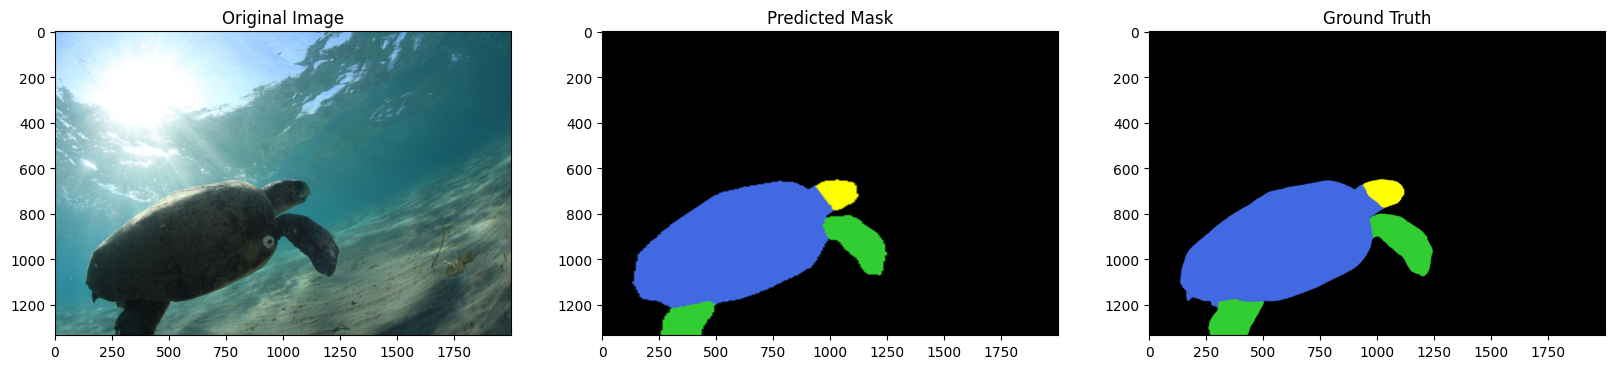

In [48]:
display_fcn_mask(132, image_transform, model)

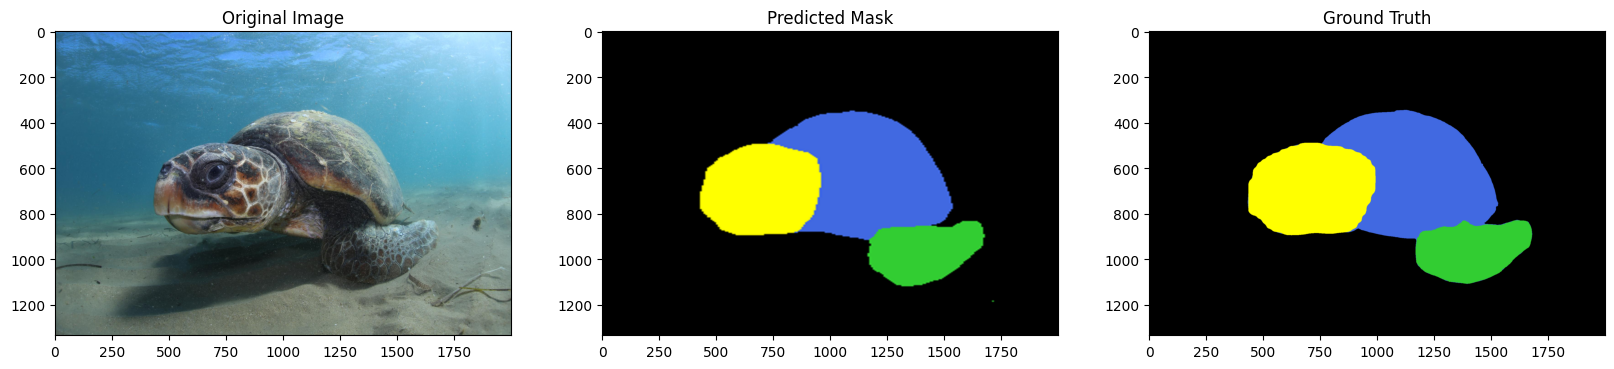

In [49]:
display_fcn_mask(5264, image_transform, model)

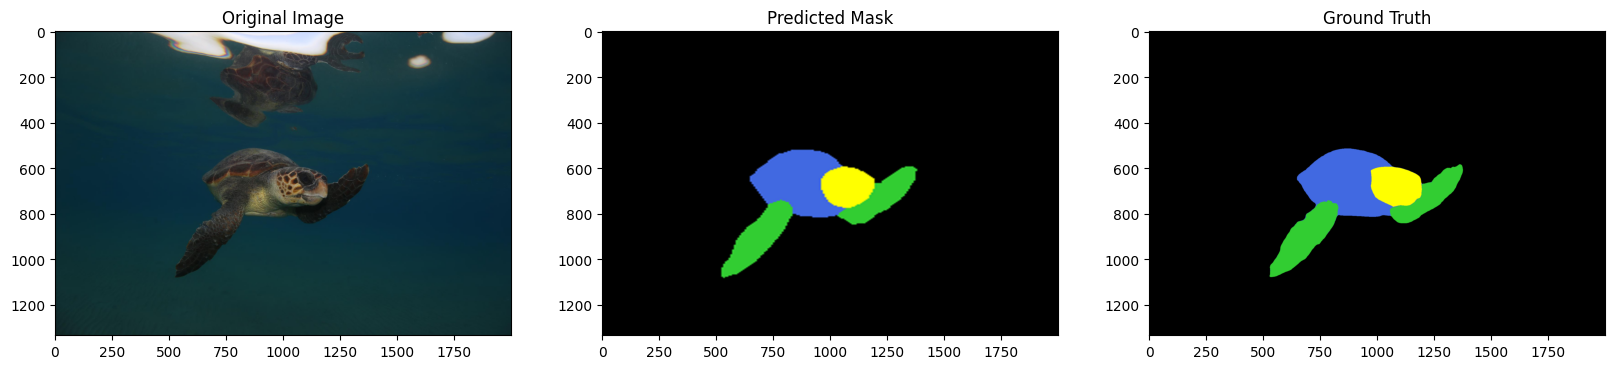

In [50]:
display_fcn_mask(7885, image_transform, model)

### FPN

The FPN (Feature Pyramid Network) model is designed for tasks like image segmentation and object detection, using a pyramid structure to capture multi-scale features.

In this line, resnet152 is set as the backbone encoder, pre-trained on ImageNet (encoder_weights="imagenet"), to extract rich features across layers. The model takes 3-channel input images (in_channels=3) and outputs 4 classes (classes=4).

In [51]:
model = FPN(encoder_name="resnet152",encoder_weights="imagenet",in_channels=3,classes=4).to(device)

In [52]:
train = TurtleDataset(train_dataset, train_transform)
valid = TurtleDataset(valid_dataset, image_transform)
test = TurtleDataset(test_dataset, image_transform)

In [53]:
train_loader = DataLoader(train, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid, batch_size=64, shuffle=False)
test_loader = DataLoader(test, batch_size=64, shuffle=False)

#### Train and Valid

Set the optimizer to AdamW, with an initial learning rate of 0.0001 and a slight weight decay to prevent overfitting.

Set the learning rate scheduler to reduce the learning rate to 10% when the validation loss stops decreasing.


In [ ]:
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
train_losses, valid_losses = [], []
train_accuracies, valid_accuracies = [], []
train_iou_scores, valid_iou_scores = [], []

iou_metric = evaluate.load("mean_iou")

for epoch in range(TRAIN_EPOCHS):
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    train_iou_score = 0.0

    for batch_idx, (data, target) in enumerate(tqdm(train_loader, desc=f'Epoch {epoch+1}/{TRAIN_EPOCHS}')):
        data, target = data.permute(0, 3, 1, 2).to(device), target.to(device)

        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target.long())
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        preds = outputs.argmax(dim=1)
        total_correct += (preds == target).sum().item()
        total_samples += target.numel()

        iou_metric.add_batch(predictions=preds.cpu().numpy(), references=target.cpu().numpy())

    train_iou_result = iou_metric.compute(num_labels=4, ignore_index=-1)

    avg_train_iou = train_iou_result["mean_iou"]
    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = train_iou_result["mean_accuracy"]

    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    train_iou_scores.append(avg_train_iou)

    print(f'Epoch [{epoch+1}/{TRAIN_EPOCHS}], Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Train IoU: {avg_train_iou:.4f}')

    model.eval()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    valid_iou_score = 0.0

    iou_metric = evaluate.load("mean_iou")

    with torch.no_grad():
        for data, target in tqdm(valid_loader, desc='Validating'):
            data, target = data.permute(0, 3, 1, 2).to(device), target.to(device)

            outputs = model(data)
            loss = criterion(outputs, target.long())

            total_loss += loss.item()

            preds = outputs.argmax(dim=1)
            total_correct += (preds == target).sum().item()
            total_samples += target.numel()

            iou_metric.add_batch(predictions=preds.cpu().numpy(), references=target.cpu().numpy())

    valid_iou_result = iou_metric.compute(num_labels=4, ignore_index=-1)

    avg_valid_iou = valid_iou_result["mean_iou"]
    avg_valid_loss = total_loss / len(valid_loader)
    valid_accuracy = valid_iou_result["mean_accuracy"]

    valid_losses.append(avg_valid_loss)
    valid_accuracies.append(valid_accuracy)
    valid_iou_scores.append(avg_valid_iou)

    # torch.save(model.state_dict(), f'/content/drive/MyDrive/pth/FPN/epoch_{epoch + 1}.pth')

    print(f'Epoch [{epoch+1}/{TRAIN_EPOCHS}], Valid Loss: {avg_valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.4f}, Valid IoU: {avg_valid_iou:.4f}')

    scheduler.step(avg_valid_loss)

Epoch 1/15: 100%|██████████| 83/83 [08:14<00:00,  5.96s/it]


Epoch [1/15], Train Loss: 0.1541, Train Accuracy: 0.7842, Train IoU: 0.6736


Validating: 100%|██████████| 18/18 [01:30<00:00,  5.04s/it]


Epoch [1/15], Valid Loss: 0.0588, Valid Accuracy: 0.8742, Valid IoU: 0.8128


Epoch 2/15: 100%|██████████| 83/83 [08:22<00:00,  6.05s/it]


Epoch [2/15], Train Loss: 0.0565, Train Accuracy: 0.9020, Train IoU: 0.8399


Validating: 100%|██████████| 18/18 [01:30<00:00,  5.05s/it]


Epoch [2/15], Valid Loss: 0.0437, Valid Accuracy: 0.9207, Valid IoU: 0.8571


Epoch 3/15: 100%|██████████| 83/83 [08:17<00:00,  6.00s/it]


Epoch [3/15], Train Loss: 0.0473, Train Accuracy: 0.9222, Train IoU: 0.8677


Validating: 100%|██████████| 18/18 [01:32<00:00,  5.15s/it]


Epoch [3/15], Valid Loss: 0.0391, Valid Accuracy: 0.9274, Valid IoU: 0.8722


Epoch 4/15: 100%|██████████| 83/83 [08:22<00:00,  6.05s/it]


Epoch [4/15], Train Loss: 0.0392, Train Accuracy: 0.9334, Train IoU: 0.8850


Validating: 100%|██████████| 18/18 [01:32<00:00,  5.13s/it]


Epoch [4/15], Valid Loss: 0.0344, Valid Accuracy: 0.9337, Valid IoU: 0.8834


Epoch 5/15: 100%|██████████| 83/83 [08:17<00:00,  5.99s/it]


Epoch [5/15], Train Loss: 0.0345, Train Accuracy: 0.9413, Train IoU: 0.8971


Validating: 100%|██████████| 18/18 [01:33<00:00,  5.17s/it]


Epoch [5/15], Valid Loss: 0.0329, Valid Accuracy: 0.9345, Valid IoU: 0.8865


Epoch 6/15: 100%|██████████| 83/83 [08:20<00:00,  6.03s/it]


Epoch [6/15], Train Loss: 0.0320, Train Accuracy: 0.9462, Train IoU: 0.9041


Validating: 100%|██████████| 18/18 [01:32<00:00,  5.15s/it]


Epoch [6/15], Valid Loss: 0.0305, Valid Accuracy: 0.9418, Valid IoU: 0.8962


Epoch 7/15: 100%|██████████| 83/83 [08:12<00:00,  5.93s/it]


Epoch [7/15], Train Loss: 0.0297, Train Accuracy: 0.9497, Train IoU: 0.9097


Validating: 100%|██████████| 18/18 [01:31<00:00,  5.09s/it]


Epoch [7/15], Valid Loss: 0.0302, Valid Accuracy: 0.9377, Valid IoU: 0.8969


Epoch 8/15: 100%|██████████| 83/83 [08:15<00:00,  5.97s/it]


Epoch [8/15], Train Loss: 0.0282, Train Accuracy: 0.9522, Train IoU: 0.9137


Validating: 100%|██████████| 18/18 [01:31<00:00,  5.09s/it]


Epoch [8/15], Valid Loss: 0.0296, Valid Accuracy: 0.9459, Valid IoU: 0.8998


Epoch 9/15: 100%|██████████| 83/83 [08:17<00:00,  5.99s/it]


Epoch [9/15], Train Loss: 0.0269, Train Accuracy: 0.9544, Train IoU: 0.9170


Validating: 100%|██████████| 18/18 [01:32<00:00,  5.14s/it]


Epoch [9/15], Valid Loss: 0.0297, Valid Accuracy: 0.9434, Valid IoU: 0.9007


Epoch 10/15: 100%|██████████| 83/83 [08:19<00:00,  6.01s/it]


Epoch [10/15], Train Loss: 0.0268, Train Accuracy: 0.9547, Train IoU: 0.9180


Validating: 100%|██████████| 18/18 [01:31<00:00,  5.07s/it]


Epoch [10/15], Valid Loss: 0.0378, Valid Accuracy: 0.9391, Valid IoU: 0.8849


Epoch 11/15: 100%|██████████| 83/83 [08:19<00:00,  6.01s/it]


Epoch [11/15], Train Loss: 0.0270, Train Accuracy: 0.9546, Train IoU: 0.9169


Validating: 100%|██████████| 18/18 [01:30<00:00,  5.05s/it]


Epoch [11/15], Valid Loss: 0.0287, Valid Accuracy: 0.9386, Valid IoU: 0.9035


Epoch 12/15: 100%|██████████| 83/83 [08:16<00:00,  5.98s/it]


Epoch [12/15], Train Loss: 0.0258, Train Accuracy: 0.9563, Train IoU: 0.9200


Validating: 100%|██████████| 18/18 [01:30<00:00,  5.05s/it]


Epoch [12/15], Valid Loss: 0.0272, Valid Accuracy: 0.9477, Valid IoU: 0.9064


Epoch 13/15: 100%|██████████| 83/83 [08:18<00:00,  6.00s/it]


Epoch [13/15], Train Loss: 0.0268, Train Accuracy: 0.9567, Train IoU: 0.9203


Validating: 100%|██████████| 18/18 [01:30<00:00,  5.03s/it]


Epoch [13/15], Valid Loss: 0.0374, Valid Accuracy: 0.9250, Valid IoU: 0.8796


Epoch 14/15: 100%|██████████| 83/83 [08:14<00:00,  5.96s/it]


Epoch [14/15], Train Loss: 0.0294, Train Accuracy: 0.9514, Train IoU: 0.9126


Validating: 100%|██████████| 18/18 [01:32<00:00,  5.16s/it]


Epoch [14/15], Valid Loss: 0.0298, Valid Accuracy: 0.9443, Valid IoU: 0.8993


Epoch 15/15: 100%|██████████| 83/83 [08:11<00:00,  5.92s/it]


Epoch [15/15], Train Loss: 0.0247, Train Accuracy: 0.9586, Train IoU: 0.9235


Validating: 100%|██████████| 18/18 [01:32<00:00,  5.16s/it]


Epoch [15/15], Valid Loss: 0.0269, Valid Accuracy: 0.9491, Valid IoU: 0.9091


##### Train and validate image generation

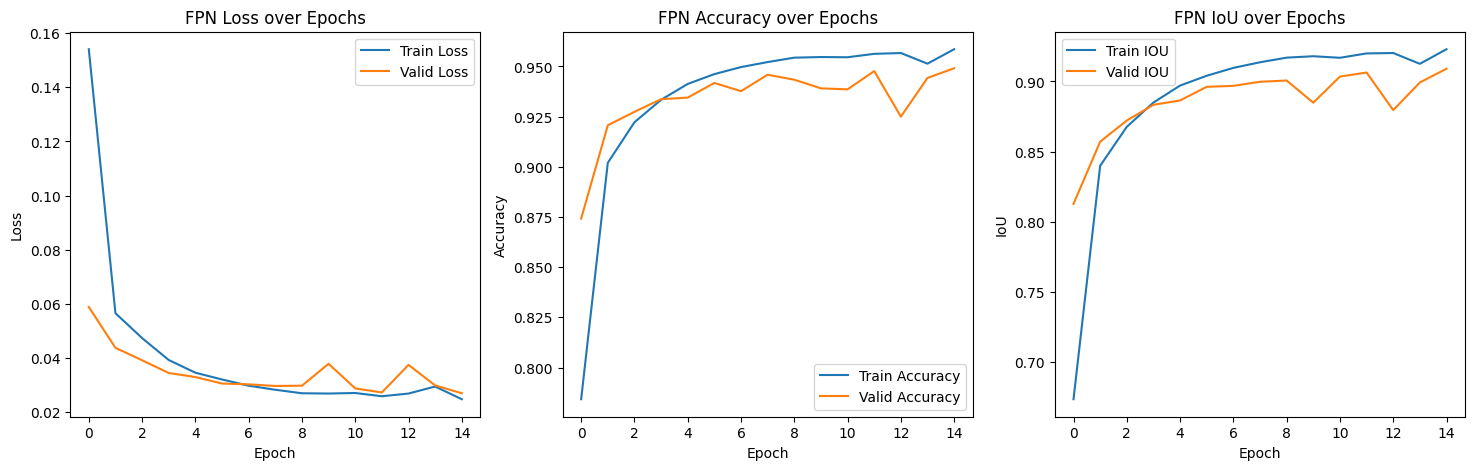

In [ ]:
plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('FPN Loss over Epochs')

plt.subplot(1, 3, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(valid_accuracies, label='Valid Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('FPN Accuracy over Epochs')

plt.subplot(1, 3, 3)
plt.plot(train_iou_scores, label='Train IOU')
plt.plot(valid_iou_scores, label='Valid IOU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()
plt.title('FPN IoU over Epochs')

plt.show()

#### Evaluation

In [54]:
pth = hf_hub_download(repo_id=repo_id, filename="FPN.pth")
model.load_state_dict(torch.load(pth))

FPN.pth:   0%|          | 0.00/244M [00:00<?, ?B/s]

<All keys matched successfully>

In [59]:
iou_metric = evaluate.load("mean_iou")

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for data, target in tqdm(test_loader):
        data, target = data.permute(0, 3, 1, 2).to(device), target.to(device)

        outputs = model(data)
        preds = outputs.argmax(dim=1).cpu().numpy()
        labels = target.cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels)

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

num_classes = 4
iou_result = iou_metric.compute(predictions=all_preds, references=all_labels, num_labels=4, ignore_index=-1)

print(f"""FPN (Resnet152):
  Mean IoU: {iou_result['mean_iou']:.4f}
  Mean Accuracy: {iou_result['mean_accuracy']:.4f}

  Mean IoU of backdrop: {iou_result['per_category_iou'][0]:.4f}
  Mean Accuracy of backdrop: {iou_result['per_category_accuracy'][0]:.4f}

  Mean IoU of turtle: {iou_result['per_category_iou'][1]:.4f}
  Mean Accuracy of turtle: {iou_result['per_category_accuracy'][1]:.4f}

  Mean IoU of flipper: {iou_result['per_category_iou'][2]:.4f}
  Mean Accuracy of flipper: {iou_result['per_category_accuracy'][2]:.4f}

  Mean IoU of head: {iou_result['per_category_iou'][3]:.4f}
  Mean Accuracy of head: {iou_result['per_category_accuracy'][3]:.4f}
""")

100%|██████████| 37/37 [03:17<00:00,  5.33s/it]


FPN (Resnet152):
  Mean IoU: 0.9042
  Mean Accuracy: 0.9440

  Mean IoU of backdrop: 0.9933
  Mean Accuracy of backdrop: 0.9966

  Mean IoU of turtle: 0.9242
  Mean Accuracy of turtle: 0.9708

  Mean IoU of flipper: 0.8317
  Mean Accuracy of flipper: 0.8899

  Mean IoU of head: 0.8677
  Mean Accuracy of head: 0.9187



In [55]:
def display_fpn_mask(idx, transform, model):
    image = ds[idx - 1]['image']
    process = transform(image=np.array(image))['image']

    image_tensor = torch.as_tensor(process).unsqueeze(0).permute(0, 3, 1, 2).to(device)

    model.eval()
    with torch.no_grad():
        mask = model(image_tensor)
        pred = mask.argmax(dim=1).cpu().numpy()

    plt.figure(figsize=(20, 5))

    plt.subplot(1, 3, 1)
    plt.title('Original Image')
    plt.imshow(image)

    plt.subplot(1, 3, 2)
    plt.title('Predicted Mask')
    color_mapped_image = np.array([COLOR[label] for label in pred[0].flatten()])
    color_mapped_image = color_mapped_image.reshape((*pred[0].shape, 3))

    pil_image = Image.fromarray(color_mapped_image.astype('uint8'))

    resized_image = pil_image.resize((image.size[0], image.size[1]), Image.NEAREST)
    plt.imshow(resized_image)

    plt.subplot(1, 3, 3)
    plt.title('Ground Truth')
    plt.imshow(COLOR[get_mask(idx)])
    plt.show()

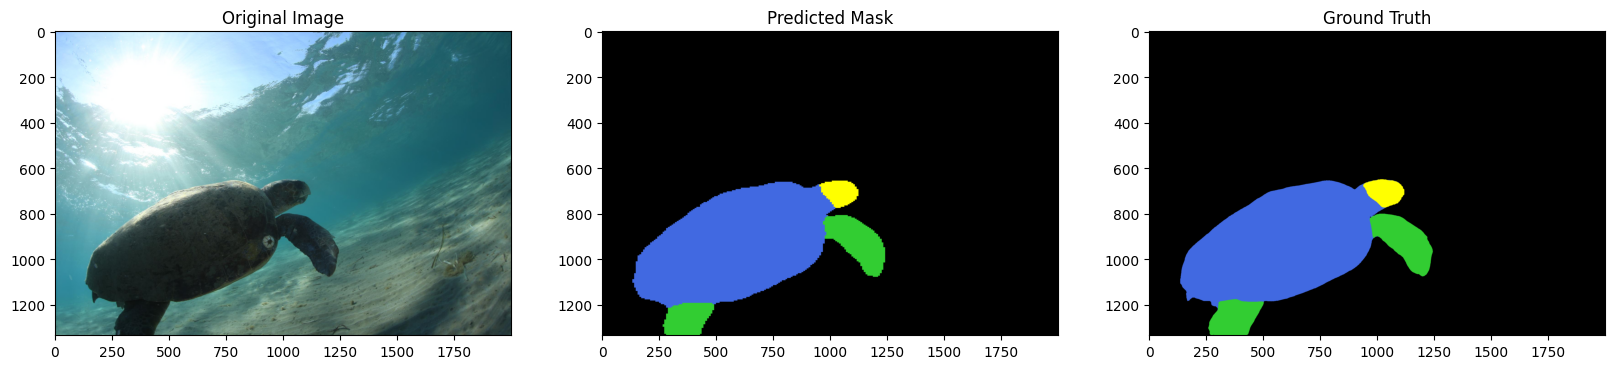

In [56]:
display_fpn_mask(132, image_transform, model)

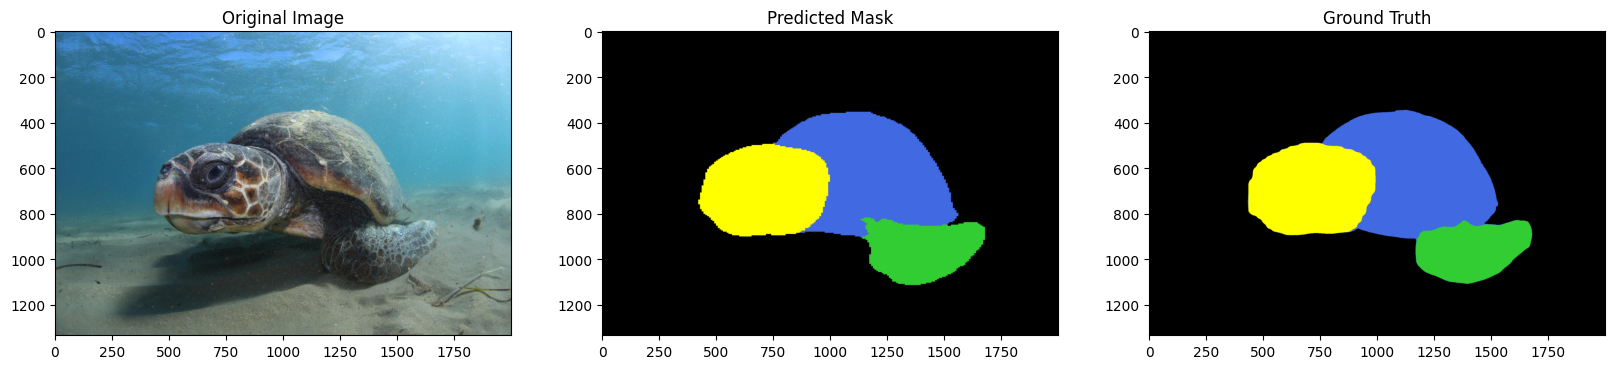

In [57]:
display_fpn_mask(5264, image_transform, model)

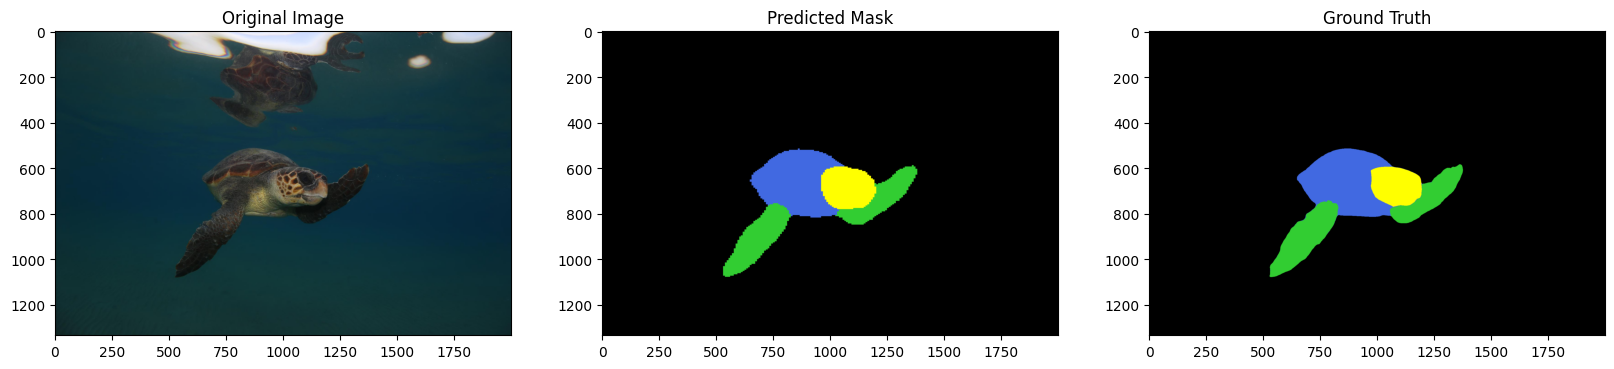

In [58]:
display_fpn_mask(7885, image_transform, model)